<a href="https://colab.research.google.com/github/FabrizioBettetti/Machine-learning/blob/main/Classification_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [2]:
train_images.ndim   #Rank

3

In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
train_images.dtype

dtype('uint8')

In [5]:
len(train_labels)

60000

In [6]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

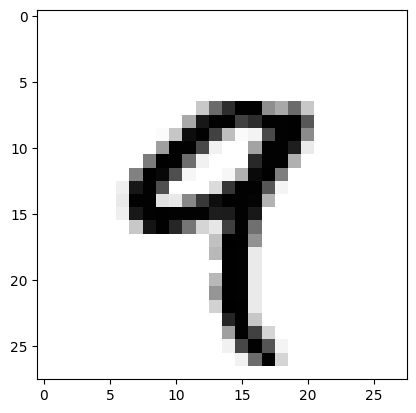

In [7]:
import matplotlib.pyplot as plt

digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [8]:
train_labels[4]

np.uint8(9)

In [9]:
test_images.shape

(10000, 28, 28)

In [10]:
len(test_labels)

10000

In [11]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')])

In [13]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [15]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8699 - loss: 0.4465
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9658 - loss: 0.1161
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9790 - loss: 0.0727
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9848 - loss: 0.0506
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9881 - loss: 0.0390


In [16]:
test_digits = test_images[:10]
predictions = model.predict(test_digits)
predictions[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


array([1.2410315e-07, 4.4611075e-09, 6.7612914e-06, 5.6194704e-06,
       5.0724189e-11, 2.6054002e-08, 9.5292663e-12, 9.9998689e-01,
       7.2535087e-08, 4.8058376e-07], dtype=float32)

In [17]:
predictions[0].argmax()   #Index of highest probability

np.int64(7)

In [18]:
predictions[0][7]

np.float32(0.9999869)

In [19]:
test_labels[0]

np.uint8(7)

In [20]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'test_acc: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9781 - loss: 0.0799
test_acc: 0.9807999730110168


##From scratch

In [21]:
import tensorflow as tf

class NaiveDense:
  def __init__(self, input_size, output_size, activation):   #input_size = 28 * 28 = 784, output_size = 512
    self.activation = activation

    w_shape = (input_size, output_size)   #(784, 512)
    w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)   #Uniform distribution on the interval [minval, maxval)
    self.W = tf.Variable(w_initial_value)

    b_shape = (output_size,)   #(512,)
    b_initial_value = tf.zeros(b_shape)
    self.b = tf.Variable(b_initial_value)

  def __call__(self, inputs):   #inputs with shape (128, 784)
    return self.activation(tf.matmul(inputs, self.W) + self.b)   #(128, 784) matmul (784, 512) + (512,) = (128, 512)  (self.b broadcasted to (128, 512))

  @property
  def weights(self):
    return [self.W, self.b]

In [22]:
class NaiveSequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, inputs):
    x = inputs
    for layer in self.layers:
      x = layer(x)
    return x

  @property
  def weights(self):
    weights = []
    for layer in self.layers:
      weights += layer.weights
    return weights

In [23]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

In [24]:
import math

class BatchGenerator:
  def __init__(self, images, labels, batch_size=128):   #images: train images of shape (60000, 784); labels: train labels of shape (60000,)
    assert len(images) == len(labels)   #len return the number of elements in the first axis (60000 == 60000)
    self.index = 0
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.num_batches = math.ceil(len(images) / batch_size)   #ceil(60000 / 128) = 469

  def next(self):
    images = self.images[self.index : self.index + self.batch_size]   #[] operator acts on first axis. Extracts 128 images (except last batch)
    labels = self.labels[self.index : self.index + self.batch_size]   #Extracts 128 labels (except last batch)
    self.index += self.batch_size   #Move index to the start of next batch size
    return images, labels

In [25]:
def one_training_step(model, images_batch, labels_batch):
  with tf.GradientTape() as tape:
    predictions = model(images_batch)   #Invoke __call__ of NaiveSequential with argument inputs = images_batch
    per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, predictions)
    average_loss = tf.reduce_mean(per_sample_losses)
  gradients = tape.gradient(average_loss, model.weights)
  update_weights(gradients, model.weights)
  return average_loss

In [26]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
  optimizer.apply_gradients(zip(gradients, weights))

In [27]:
def fit(model, images, labels, epochs, batch_size=128):
  for epoch_counter in range(epochs):
    print(f'epoch {epoch_counter}')
    batch_generator = BatchGenerator(images, labels, batch_size)
    for batch_counter in range(batch_generator.num_batches):
      images_batch, labels_batch = batch_generator.next()
      loss = one_training_step(model, images_batch, labels_batch)
      if batch_counter % 100 == 0:
        print(f'loss at batch {batch_counter}: {loss:.2f}')

In [28]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

epoch 0
loss at batch 0: 4.79
loss at batch 100: 2.24
loss at batch 200: 2.19
loss at batch 300: 2.09
loss at batch 400: 2.19
epoch 1
loss at batch 0: 1.90
loss at batch 100: 1.87
loss at batch 200: 1.81
loss at batch 300: 1.70
loss at batch 400: 1.79
epoch 2
loss at batch 0: 1.57
loss at batch 100: 1.57
loss at batch 200: 1.48
loss at batch 300: 1.41
loss at batch 400: 1.48
epoch 3
loss at batch 0: 1.32
loss at batch 100: 1.34
loss at batch 200: 1.22
loss at batch 300: 1.20
loss at batch 400: 1.26
epoch 4
loss at batch 0: 1.13
loss at batch 100: 1.15
loss at batch 200: 1.03
loss at batch 300: 1.04
loss at batch 400: 1.10
epoch 5
loss at batch 0: 0.98
loss at batch 100: 1.02
loss at batch 200: 0.90
loss at batch 300: 0.92
loss at batch 400: 0.98
epoch 6
loss at batch 0: 0.88
loss at batch 100: 0.91
loss at batch 200: 0.80
loss at batch 300: 0.83
loss at batch 400: 0.90
epoch 7
loss at batch 0: 0.80
loss at batch 100: 0.83
loss at batch 200: 0.72
loss at batch 300: 0.76
loss at batch 40

In [29]:
import numpy as np

predictions = model(test_images)   #predictions shape: (10000, 10)
predictions = predictions.numpy()   #predictions shape: (10000, 10)
predicted_labels = np.argmax(predictions, axis=1)   #predicted_labels shape: (10000,) (extract the index of the maximum value in the second axis)
matches = predicted_labels == test_labels
print(f'accuracy: {matches.mean():.2f}')

accuracy: 0.82


##Generalization

In [30]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

Noise channels, all-zero channels

In [31]:
train_images_with_noise_channels = np.concatenate([train_images, np.random.random((len(train_images), 784))], axis=1)
train_images_with_zero_channels = np.concatenate([train_images, np.zeros((len(train_images), 784))], axis=1)

In [32]:
train_images_with_noise_channels.shape

(60000, 1568)

In [33]:
train_images_with_zero_channels.shape

(60000, 1568)

In [34]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
  model = keras.Sequential([
      layers.Dense(512, activation='relu'),
      layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

model = get_model()
history_noise = model.fit(train_images_with_noise_channels,
                          train_labels,
                          epochs=10,
                          batch_size=128,
                          validation_split=0.2)

model = get_model()
history_zeros = model.fit(train_images_with_zero_channels,
                          train_labels,
                          epochs=10,
                          batch_size=128,
                          validation_split=0.2)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6916 - loss: 1.0984 - val_accuracy: 0.9156 - val_loss: 0.2846
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9146 - loss: 0.2768 - val_accuracy: 0.9420 - val_loss: 0.1927
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9470 - loss: 0.1703 - val_accuracy: 0.9564 - val_loss: 0.1467
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9606 - loss: 0.1233 - val_accuracy: 0.9566 - val_loss: 0.1412
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9739 - loss: 0.0869 - val_accuracy: 0.9566 - val_loss: 0.1528
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9790 - loss: 0.0649 - val_accuracy: 0.9484 - val_loss: 0.1732
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9856 - loss: 0.0466 - val_accuracy: 0.9647 - val_loss: 0.1207
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9902 - loss: 0.0320 - val_accuracy: 0.

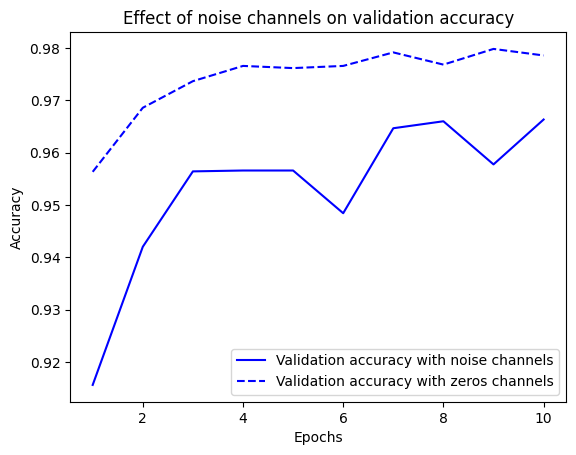

In [35]:
import matplotlib.pyplot as plt

val_acc_noise = history_noise.history['val_accuracy']
val_acc_zeros = history_zeros.history['val_accuracy']
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, 'b-', label='Validation accuracy with noise channels')
plt.plot(epochs, val_acc_zeros, 'b--', label='Validation accuracy with zeros channels')
plt.title('Effect of noise channels on validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Randomly shuffled labels

In [36]:
random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, random_train_labels, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1025 - loss: 2.3405 - val_accuracy: 0.1008 - val_loss: 2.3091
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1170 - loss: 2.2988 - val_accuracy: 0.1017 - val_loss: 2.3112
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1306 - loss: 2.2895 - val_accuracy: 0.0993 - val_loss: 2.3167
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1420 - loss: 2.2762 - val_accuracy: 0.1003 - val_loss: 2.3212
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1557 - loss: 2.2581 - val_accuracy: 0.0978 - val_loss: 2.3348
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1680 - loss: 2.2399 - val_accuracy: 0.1007 - val_loss: 2.3477
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1823 - loss: 2.2149 - val_accuracy: 0.1011 - val_loss: 2.3672
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2017 - loss: 2.1870 - val_accu

In [37]:
model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1052 - loss: 7.7572


[7.491204738616943, 0.11029999703168869]

#Error in learning rate

In [38]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

In [39]:
model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer=keras.optimizers.RMSprop(1.), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2)

#High learning rate => val_accuracy low

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3695 - loss: 2451.6826 - val_accuracy: 0.1558 - val_loss: 2.3759
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1775 - loss: 4.5826 - val_accuracy: 0.1734 - val_loss: 2.8652
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1881 - loss: 2.4976 - val_accuracy: 0.2400 - val_loss: 2.1152
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1889 - loss: 2.7669 - val_accuracy: 0.1964 - val_loss: 2.2331
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2134 - loss: 2.6072 - val_accuracy: 0.2582 - val_loss: 2.3036
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2096 - loss: 2.3494 - val_accuracy: 0.2682 - val_loss: 2.1351
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2338 - loss: 2.3301 - val_accuracy: 0.2832 - val_loss: 2.9975
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2600 - loss: 2.4846 - val_accuracy:

In [40]:
model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2)

#Lower learning rate => higher val_accuracy

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8416 - loss: 0.7718 - val_accuracy: 0.9628 - val_loss: 0.1300
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9628 - loss: 0.1281 - val_accuracy: 0.9569 - val_loss: 0.1821
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9736 - loss: 0.0961 - val_accuracy: 0.9684 - val_loss: 0.1428
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9806 - loss: 0.0719 - val_accuracy: 0.9695 - val_loss: 0.1493
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9848 - loss: 0.0596 - val_accuracy: 0.9711 - val_loss: 0.1732
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9853 - loss: 0.0595 - val_accuracy: 0.9703 - val_loss: 0.1999
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9891 - loss: 0.0423 - val_accuracy: 0.9682 - val_loss: 0.2284
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9882 - loss: 0.0460 - val_accuracy: 0.

#Try to overfit

In [41]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

In [42]:
model = keras.Sequential([layers.Dense(10, activation='softmax')])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_small_model = model.fit(train_images, train_labels, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7310 - loss: 1.0451 - val_accuracy: 0.9028 - val_loss: 0.3610
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9018 - loss: 0.3613 - val_accuracy: 0.9149 - val_loss: 0.3103
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9133 - loss: 0.3145 - val_accuracy: 0.9186 - val_loss: 0.2931
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9166 - loss: 0.3053 - val_accuracy: 0.9192 - val_loss: 0.2844
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9168 - loss: 0.2926 - val_accuracy: 0.9229 - val_loss: 0.2784
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9213 - loss: 0.2873 - val_accuracy: 0.9253 - val_loss: 0.2738
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9228 - loss: 0.2769 - val_accuracy: 0.9247 - val_loss: 0.2745
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9227 - loss: 0.2758 - val_accuracy: 0.

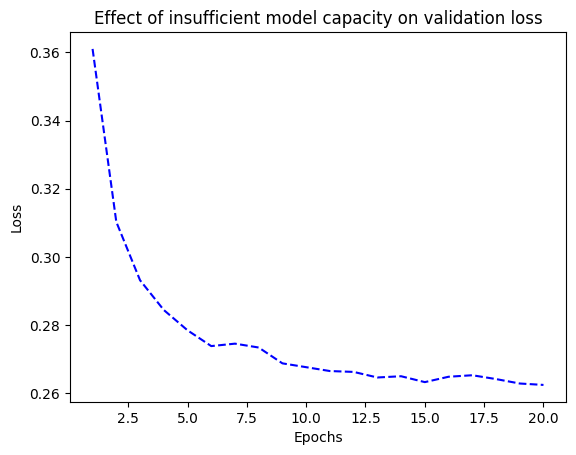

In [43]:
import matplotlib.pyplot as plt

val_loss = history_small_model.history['val_loss']
epochs = range(1, 21)
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Effect of insufficient model capacity on validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

The previous model is unable to overfit

In [44]:
model = keras.Sequential([
    layers.Dense(96, activation='relu'),
    layers.Dense(96, activation='relu'),
    layers.Dense(10, activation='softmax')])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_large_model = model.fit(train_images, train_labels, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8253 - loss: 0.6104 - val_accuracy: 0.9394 - val_loss: 0.2043
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9472 - loss: 0.1770 - val_accuracy: 0.9583 - val_loss: 0.1387
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9646 - loss: 0.1190 - val_accuracy: 0.9654 - val_loss: 0.1136
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9729 - loss: 0.0887 - val_accuracy: 0.9696 - val_loss: 0.0974
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9786 - loss: 0.0703 - val_accuracy: 0.9728 - val_loss: 0.0915
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9824 - loss: 0.0546 - val_accuracy: 0.9743 - val_loss: 0.0939
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9864 - loss: 0.0444 - val_accuracy: 0.9713 - val_loss: 0.1037
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9886 - loss: 0.0398 - val_accuracy: 0.

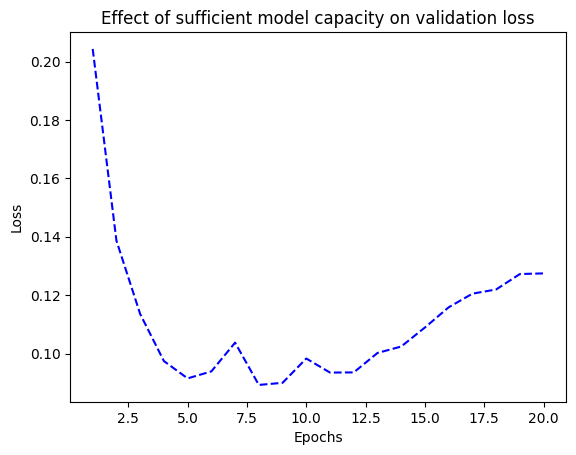

In [45]:
import matplotlib.pyplot as plt

val_loss = history_large_model.history['val_loss']
epochs = range(1, 21)
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Effect of sufficient model capacity on validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Overfitting reached